In [1]:
import torch
import torch.nn as nn
import math

class InputEmbeddings(nn.Module):
    """
    Converts integer token IDs (e.g., [4, 102, 5]) into dense vectors.
    """
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        # The lookup table
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # x shape: (Batch, Seq_Len)
        # We multiply by sqrt(d_model) to increase the magnitude of embeddings 
        # so they aren't overwhelmed by the Positional Encodings added next.
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    """
    Adds geometric vectors to the embeddings so the model knows 'Order'.
    Without this, "Man bites Dog" looks the same as "Dog bites Man".
    """
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create a matrix of shape (Seq_Len, d_model) representing positions
        pe = torch.zeros(seq_len, d_model)
        
        # 1. Create a vector [0, 1, 2, ... seq_len]
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        
        # 2. Create the division term for the sine/cosine formulas
        # This calculates 1 / (10000^(2i/d_model)) in log space for stability
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # 3. Apply Sine to even indices and Cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add Batch dimension so we can broadcast to any batch size later
        # Shape becomes (1, Seq_Len, d_model)
        pe = pe.unsqueeze(0)

        # register_buffer saves this tensor to the model file, but tells PyTorch
        # "Do not update this with gradients" (it's fixed, not learned).
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, d_model)
        # We slice self.pe to the length of x (in case x is shorter than max seq_len)
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)


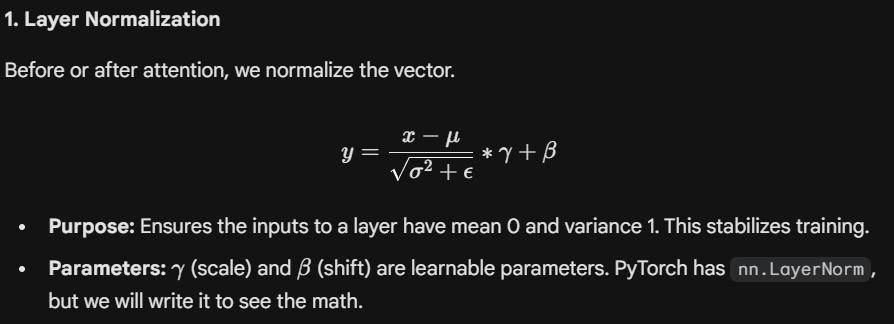

Instead of one huge attention focus, we split the embedding into $h$ heads.

**Parameters:**
- Total Dimension ($d_{model}$): 512
- Heads ($h$): 8
- Head Dimension ($d_k$): $512 / 8 = 64$

**The Flow:**

1. **Linear Projections**: We have three separate linear layers ($W_q, W_k, W_v$) that project input $x$ into Q, K, and V.
2. **Splitting Heads**: We reshape the tensor from (Batch, Seq_Len, d_model) to (Batch, Seq_Len, h, d_k).
3. **Transpose**: We swap dimensions to (Batch, h, Seq_Len, d_k) so that each head processes the sequence independently in parallel.
4. **Scaled Dot-Product**: Calculate scores, apply mask (if any), apply softmax.
5. **Concat**: Merge the heads back together.
6. **Final Linear**: A final mixing layer ($W_o$).

In [2]:
class LayerNormalization(nn.Module):
    """
    Implements: (x - mean) / std * gamma + beta
    Why? To ensure that the inputs to layers have a mean of 0 and variance of 1.
    This stabilizes the learning process.
    """
    def __init__(self, eps: float = 10**-6):
        super().__init__()
        self.eps = eps
        # We make alpha (multiplicative) and bias (additive) learnable parameters.
        self.alpha = nn.Parameter(torch.ones(1)) 
        self.bias = nn.Parameter(torch.zeros(1)) 

    def forward(self, x):
        # x shape: (Batch, Seq_Len, d_model)
        # Keepdim=True preserves the dimension so we can broadcast subtraction
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.h = h # Number of heads
        
        assert d_model % h == 0, "d_model must be divisible by h"
        
        self.d_k = d_model // h # Dimension of one head (e.g., 512 / 8 = 64)
        
        # The 4 Linear layers needed
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o (Final output projection)
        
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        """
        The Core Math: Softmax(QK^T / sqrt(d_k)) * V
        """
        d_k = query.shape[-1]
        
        # 1. Dot Product (Matrix Multiplication)
        # Query: (Batch, h, Seq_Len, d_k)
        # Key^T: (Batch, h, d_k, Seq_Len) -> Transposed last two dims
        # Result: (Batch, h, Seq_Len, Seq_Len) -> The "Correlation Map"
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        
        # 2. Masking (Optional)
        # Used in Decoder to prevent cheating (looking at future words)
        if mask is not None:
            # We replace values with -1e9 where mask == 0
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
            
        # 3. Softmax
        # Normalizes scores to probabilities (0.0 to 1.0)
        attention_weights = attention_scores.softmax(dim=-1)
        
        if dropout is not None:
            attention_weights = dropout(attention_weights)
            
        # 4. Multiply by Values
        # Weights: (Batch, h, Seq_Len, Seq_Len)
        # Values:  (Batch, h, Seq_Len, d_k)
        # Result:  (Batch, h, Seq_Len, d_k)
        return (attention_weights @ value), attention_weights

    def forward(self, q, k, v, mask):
        # q, k, v input shape: (Batch, Seq_Len, d_model)
        
        # 1. Project through linear layers
        query = self.w_q(q) 
        key = self.w_k(k)
        value = self.w_v(v)
        
        # 2. Split into Heads (Reshape & Transpose)
        # View: (Batch, Seq_Len, h, d_k)
        # Transpose: (Batch, h, Seq_Len, d_k) -> Moves 'h' to dim 1 for parallel processing
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
        
        # 3. Calculate Attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # 4. Concatenate Heads
        # Transpose back: (Batch, Seq_Len, h, d_k)
        # Contiguous: Fixes memory layout after transpose
        # View: Flatten back to (Batch, Seq_Len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        
        # 5. Final Linear Projection
        return self.w_o(x)


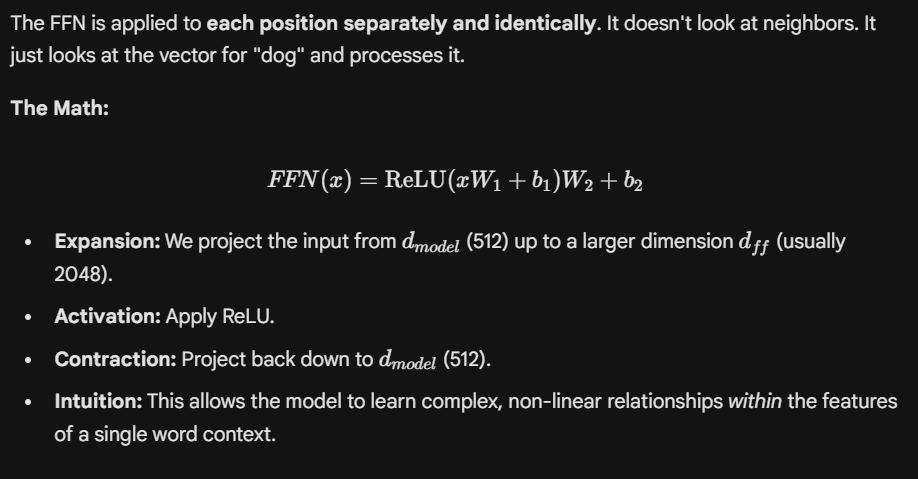

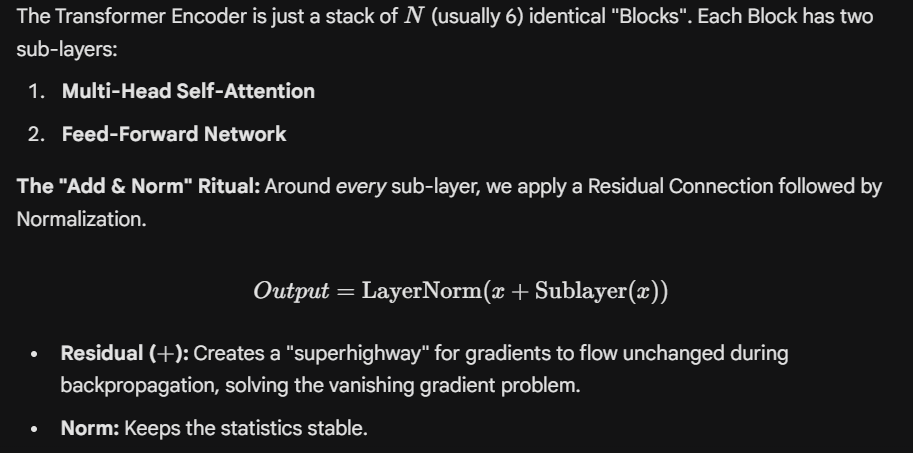

# The Residual Connection (The Safety Net)

In Deep Learning, the deeper you go (more layers), the harder it is to train.

## The Problem
As the signal passes through many layers ($f(x)$), it gets distorted, and gradients vanish (become zero) during backpropagation. The network "forgets" the original input.

## The Solution
We create a "shortcut" or a "skip connection."

**The Math:**
$$\text{Output} = x + \text{Layer}(x)$$

## Example: Translating a Sentence

- **Input ($x$)**: "The dog."
- **Layer ($f(x)$)**: Tries to add context, but might mess up and output "noise."
- **Residual ($x + f(x)$)**: We take the calculated context PLUS the original "The dog."

Even if the layer ($f(x)$) learns nothing (outputs 0), the output is still $x$ ("The dog"). The signal is preserved.

In [3]:
class FeedForwardBlock(nn.Module):
    """
    A simple two-layer fully connected network.
    It expands the dimension (d_model -> d_ff) and then contracts it back (d_ff -> d_model).
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        # Layer 1: Expansion (512 -> 2048)
        self.linear_1 = nn.Linear(d_model, d_ff) 
        self.dropout = nn.Dropout(dropout)
        # Layer 2: Contraction (2048 -> 512)
        self.linear_2 = nn.Linear(d_ff, d_model) 

    def forward(self, x):
        # x shape: (Batch, Seq_Len, d_model)
        
        # Linear -> ReLU -> Dropout -> Linear
        # (Batch, Seq_Len, d_ff)
        x = torch.relu(self.linear_1(x)) 
        x = self.dropout(x)
        
        # (Batch, Seq_Len, d_model)
        return self.linear_2(x)

class EncoderBlock(nn.Module):
    """
    One layer of the Encoder.
    Contains: Self-Attention -> Add & Norm -> Feed Forward -> Add & Norm
    """
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        
        # We need two residual connections (one for attn, one for ffn)
        self.residual_connections = nn.ModuleList([
            ResidualConnection(features, dropout) for _ in range(2)
        ])

    def forward(self, x, src_mask):
        # x shape: (Batch, Seq_Len, d_model)
        
        # 1. Self-Attention Sublayer
        # The lambda function wraps the call so the ResidualConnection can execute it
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        
        # 2. Feed-Forward Sublayer
        x = self.residual_connections[1](x, self.feed_forward_block)
        
        return x

class ResidualConnection(nn.Module):
    """
    Helper Layer: Output = LayerNorm(x + Sublayer(x))
    """
    def __init__(self, features: int, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features) # Using our custom class

    def forward(self, x, sublayer):
        # We apply the sublayer (Attention or FeedForward)
        # Then add the original 'x' (Residual)
        # Then Normalize
        return x + self.dropout(sublayer(self.norm(x)))
        # Note: The original paper does Norm(x + Sublayer(x)). 
        # Many modern implementations (Pre-LN) do x + Sublayer(Norm(x)).
        # The code above actually implements Pre-LN (Norm applied before sublayer), 
        # which is often more stable for deep transformers.

class Encoder(nn.Module):
    """
    Corrected Encoder that accepts d_model (features) as an argument.
    """
    def __init__(self, features: int, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


# Summary of the Encoder

1. **Embeddings**: Turn words into vectors.

2. **Positional Encoding**: Add order info.

3. **Encoder Block 1**:
   - Look at neighbors (Attention).
   - Remember original info (Residual).
   - Process features (FFN).
   - Remember previous info (Residual).

4. **Encoder Block 2**: Takes the result of Block 1 and does it again (refining the understanding).

5. **...**

6. **Encoder Block 6**: Outputs the final "Understanding" of the sentence.

## Decoder
The Encoder understands the input language (e.g., English). The Decoder's job is to generate the output language (e.g., French), one word at a time.

### 1. Masked Self-Attention (The "No Peeking" Rule)

**Goal**: Look at the previous words generated by the Decoder to understand the context.

**Constraint**: When predicting word #4, the model cannot see word #5. If it could, it would just copy the training data instead of learning to translate.

**The Solution**: We use a **Causal Mask** (a lower-triangular matrix). This forces the attention scores for future positions to be $-\infty$, effectively zeroing them out.

### 2. Cross-Attention (The Bridge)

This is where the magic happens. This layer connects the Encoder (English) to the Decoder (French).

- **Query ($Q$)**: Comes from the Decoder. ("I just generated the word 'Le', what should I look for next?")
- **Key ($K$) & Value ($V$)**: Come from the Encoder Output. ("Here is the entire English sentence context.")
- **Result**: The Decoder learns to focus on specific English words (e.g., "dog") when generating the corresponding French word ("chien").

### 3. Feed-Forward Network

Same as the Encoder. Processes the information.

### 4. Projection Layer

At the very end, we have a vector of size 512 ($d_{model}$). We need to turn this into a probability distribution over the entire vocabulary (e.g., 30,000 words).

**Operation**: Linear Layer (512 $\to$ Vocab Size) $\to$ Softmax.


### 1. Masked Self-Attention (The "No Peeking" Rule)

**Goal**: Look at the previous words generated by the Decoder to understand the context.

**Constraint**: When predicting word #4, the model cannot see word #5. If it could, it would just copy the training data instead of learning to translate.

**The Solution**: We use a **Causal Mask** (a lower-triangular matrix). This forces the attention scores for future positions to be $-\infty$, effectively zeroing them out.

### 2. Cross-Attention (The Bridge)

This is where the magic happens. This layer connects the Encoder (English) to the Decoder (French).

- **Query ($Q$)**: Comes from the Decoder. ("I just generated the word 'Le', what should I look for next?")
- **Key ($K$) & Value ($V$)**: Come from the Encoder Output. ("Here is the entire English sentence context.")
- **Result**: The Decoder learns to focus on specific English words (e.g., "dog") when generating the corresponding French word ("chien").

### 3. Feed-Forward Network

Same as the Encoder. Processes the information.

### 4. Projection Layer

At the very end, we have a vector of size 512 ($d_{model}$). We need to turn this into a probability distribution over the entire vocabulary (e.g., 30,000 words).

**Operation**: Linear Layer (512 $\to$ Vocab Size) $\to$ Softmax.

# The Scenario

We are translating "The cat" (English) $\to$ "Le chat" (French).

- **Encoder's Job**: It has already read "The cat". It produced a matrix of "Memory" (Context). Let's call this `encoder_output`.
- **Decoder's Job**: It has generated "`<Start>` Le". It now needs to predict the next word ("chat").

## The Data Flow: Tracing the Vectors

Imagine we are holding a single tensor called `x`. This `x` represents the Decoder's current knowledge.

### 1. The Input (What goes in?)

The input to the Decoder is not the English sentence. It is the French sentence so far.

- **Input Data**: ["`<Start>`", "Le"]
- **Vector Shape**: (Batch=1, Seq_Len=2, Dim=512)
  - Row 1: Vector for `<Start>`
  - Row 2: Vector for Le

**Status of x**: "I know I started, and I know the current word is 'Le'. I don't know English yet."

### 2. Layer 1: Masked Self-Attention (The "Rearview Mirror")

This layer helps the word "Le" understand its grammatical context within the French sentence.

- **The Question**: "Who am I ('Le') related to in this sentence?"
- **The Constraint**: "Le" cannot see the future (the word "chat"). If it saw "chat", it would just cheat and output "chat" without learning to translate.

**The Action**:
- "Le" (Query) looks at `<Start>` (Key).
- "Le" (Query) looks at Le (Key).
- **MASKING**: "Le" tries to look at Word #3, but hits a wall ($-\infty$).

**The Result**: A new vector for "Le" that captures "I am a determiner at the start of a sentence."

**Status of x**: "I understand the French grammar up to this point."

### 3. Layer 2: Cross-Attention (The "Bridge")

This is the most critical step. This is where **Translation** happens.

**The Inputs**:
- **Query ($Q$)**: Comes from `x` (our French "Le" vector).
- **Key ($K$) & Value ($V$)**: Come from `encoder_output` (The English "The cat" vectors).

**The Action**:

The vector Le shouts a Query: "I am a masculine singular determiner. Do you have any matching nouns?"

The Encoder vectors respond:
- "The" (Key): "I'm a determiner too. High match score!"
- "Cat" (Key): "I'm the noun you are looking for. High match score!"

The Attention Mechanism takes the Values of "The" and "Cat" and mixes them into the "Le" vector.

**Status of x**: "I am 'Le', and I now know I am referring to that specific 'cat' from the English sentence."

### 4. Layer 3: Feed-Forward Network (The "Brain")

Now that `x` contains the French context and the English meaning, the FFN processes it.

It expands the vector (512 $\to$ 2048), thinks about it, and shrinks it back (2048 $\to$ 512).

It might decide: "Okay, since I am 'Le' and I'm linked to 'cat', the next word implies a masculine feline."

**Status of x**: A highly processed vector ready to predict.

## Visualizing the Tensors Changing

Let's look at the shapes and data sources.

| Step | Layer | Input Source | Shape (Batch, Seq, Dim) | Meaning of Data |
|------|-------|--------------|-------------------------|-----------------|
| 0 | Input | French Tokens | (1, 2, 512) | Raw vectors for `<Start>`, Le |
| 1 | Self-Attn | Input ($Q,K,V$) | (1, 2, 512) | Le aware of `<Start>` (Context) |
| 2 | Cross-Attn | $Q$: From Step 1<br>$K,V$: From Encoder | (1, 2, 512) | Le enriched with "The cat" info |
| 3 | FFN | From Step 2 | (1, 2, 512) | Processed features |
| 4 | Final | Output | (1, 2, 512) | Final vector for Le |

## Why this order?

1. **Self-Attention First**: You must understand your own partial sentence before you can look at the translation source. You need to know you are dealing with a "Subject" or "Object" in French first.

2. **Cross-Attention Second**: Once you know "I am the subject," you look at the English sentence to find which subject to translate.

3. **Feed-Forward Last**: Once you have gathered all the info, you "think" (compute) to refine the vector for the final prediction.

## Key Takeaway

The Decoder input `x` stays the same shape (Batch, Seq, 512) the whole time, but it gets **smarter at every step**:

1. Starts as a dumb embedding.
2. Becomes aware of previous words.
3. Becomes aware of the English source.
4. Becomes a prediction vector.

In [4]:
class DecoderBlock(nn.Module):
    """
    One layer of the Decoder.
    Structure:
    1. Masked Self-Attention (Look at previous target words)
    2. Cross-Attention (Look at Encoder output)
    3. Feed-Forward
    """
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        
        # Three residual connections for the three sub-layers
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        """
        x: Input to the decoder (target tokens so far)
        encoder_output: The context vector from the Encoder
        src_mask: Mask for the Encoder output (ignore padding)
        tgt_mask: Mask for the Decoder input (ignore future words & padding)
        """
        
        # 1. Masked Self-Attention (Note: We pass tgt_mask here to hide future)
        # x acts as Q, K, V
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        
        # 2. Cross-Attention (The Bridge)
        # Query comes from x (Decoder)
        # Key and Value come from encoder_output
        # We use src_mask here to ignore padding tokens in the encoder output
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        
        # 3. Feed-Forward
        x = self.residual_connections[2](x, self.feed_forward_block)
        
        return x

class Decoder(nn.Module):
    """
    Corrected Decoder that accepts d_model (features) as an argument.
    """
    def __init__(self, features: int, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)
    
class ProjectionLayer(nn.Module):
    """
    Final layer to convert vector embeddings back to vocabulary probabilities.
    d_model -> vocab_size
    """
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # (Batch, Seq_Len, d_model) -> (Batch, Seq_Len, Vocab_Size)
        # We perform Log Softmax for numerical stability during training (NLLLoss expects logs)
        # However, for pure generation, just Linear is fine, but we'll include log_softmax standard.
        return torch.log_softmax(self.proj(x), dim=-1)


In [5]:
import torch.optim as optim

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # 1. Embed + Positional Encoding
        x = self.src_embed(src)
        x = self.src_pos(x)
        # 2. Run Encoder Stack
        return self.encoder(x, src_mask)

    def decode(self, tgt, encoder_output, src_mask, tgt_mask):
        # 1. Embed + Positional Encoding
        x = self.tgt_embed(tgt)
        x = self.tgt_pos(x)
        # 2. Run Decoder Stack
        return self.decoder(x, encoder_output, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # Full flow: Source -> Encoder -> Context -> Decoder -> Output
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        return self.projection_layer(decoder_output)

def build_transformer(src_vocab_size, tgt_vocab_size, src_seq_len, tgt_seq_len, d_model=512, N=6, h=8, dropout=0.1, d_ff=2048):
    # Helper to construct the full model
    c = lambda: torch.nn.Sequential() # Just a helper
    
    # Create Layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create Blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_blocks.append(EncoderBlock(d_model, 
            MultiHeadAttentionBlock(d_model, h, dropout),
            FeedForwardBlock(d_model, d_ff, dropout), 
            dropout))
            
    decoder_blocks = []
    for _ in range(N):
        decoder_blocks.append(DecoderBlock(d_model, 
            MultiHeadAttentionBlock(d_model, h, dropout), # Self Attn
            MultiHeadAttentionBlock(d_model, h, dropout), # Cross Attn
            FeedForwardBlock(d_model, d_ff, dropout), 
            dropout))
            
    # Assemble
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    projection = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Init Parameters (Xavier Initialization is crucial for Transformers)
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection)
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return transformer

# ==========================================
# DATASET & UTILS
# ==========================================

def causal_mask(size):
    # Creates a triangle matrix to hide future words
    # Value 1 = keep, Value 0 = hide
    mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return mask == 0

# Tiny Dictionary Dataset
sentences = [
    ("i like cats", "j'aime les chats"),
    ("i like dogs", "j'aime les chiens"),
    ("cats eat meat", "les chats mangent de la viande"),
    ("dogs eat meat", "les chiens mangent de la viande"),
]

# Simple Vocabulary Builder
src_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
for s, t in sentences:
    for word in s.split():
        if word not in src_vocab: src_vocab[word] = len(src_vocab)
    for word in t.split():
        if word not in tgt_vocab: tgt_vocab[word] = len(tgt_vocab)

src_idx_to_word = {v: k for k, v in src_vocab.items()}
tgt_idx_to_word = {v: k for k, v in tgt_vocab.items()}

def encode_text(text, vocab, seq_len):
    tokens = [vocab['<sos>']] + [vocab.get(w, vocab['<pad>']) for w in text.split()] + [vocab['<eos>']]
    # Pad
    while len(tokens) < seq_len:
        tokens.append(vocab['<pad>'])
    return torch.tensor(tokens[:seq_len])

# ==========================================
# TRAINING LOOP
# ==========================================

def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}...")
    
    seq_len = 10
    model = build_transformer(len(src_vocab), len(tgt_vocab), seq_len, seq_len, d_model=32, N=2, h=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0) # Ignore padding in loss
    
    model.train()
    
    # Convert data to tensors
    src_data = torch.stack([encode_text(s, src_vocab, seq_len) for s, _ in sentences]).to(device)
    tgt_data = torch.stack([encode_text(t, tgt_vocab, seq_len) for _, t in sentences]).to(device)
    
    # Training Loop
    for epoch in range(2000):
        # 1. Input for Decoder (Everything EXCEPT the last token)
        decoder_input = tgt_data[:, :-1] 
        
        # 2. Target for Loss (Everything EXCEPT the first <sos> token)
        # We want to predict the NEXT token
        tgt_expected = tgt_data[:, 1:] 
        
        # 3. Create Masks
        # Src Mask: (Batch, 1, 1, Seq) - Hide Padding
        src_mask = (src_data != 0).unsqueeze(1).unsqueeze(2).int()
        
        # Tgt Mask: (Batch, 1, Seq, Seq) - Hide Padding AND Future
        tgt_mask = (decoder_input != 0).unsqueeze(1).unsqueeze(2).int() & causal_mask(decoder_input.size(1)).to(device)
        
        # 4. Forward
        # Output shape: (Batch, Seq_Len-1, Vocab_Size)
        logits = model(src_data, decoder_input, src_mask, tgt_mask)
        
        # 5. Loss
        # Flatten predictions to (Batch*Seq, Vocab)
        loss = loss_fn(logits.view(-1, len(tgt_vocab)), tgt_expected.reshape(-1))
        
        # 6. Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 500 == 0 or epoch==0:
            print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
            # Test on training sentences
            model.eval()
            print("--- Testing at Epoch", epoch+1, "---")
            for src_sent, tgt_sent in sentences:
                pred = translate(model, src_sent, device)
                print(f"Input: {src_sent} | Predicted: {pred} | Actual: {tgt_sent}")
            model.train()
            
    return model, device

# ==========================================
# INFERENCE (GREEDY DECODE)
# ==========================================

def translate(model, sentence, device):
    model.eval()
    seq_len = 10
    
    # 1. Encode Source
    src = encode_text(sentence, src_vocab, seq_len).unsqueeze(0).to(device)
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2).int().to(device)
    
    # Calculate Encoder Output ONCE
    encoder_output = model.encode(src, src_mask)
    
    # 2. Start Decoder with <SOS>
    decoder_input = torch.tensor([[tgt_vocab['<sos>']]]).to(device)
    
    # 3. Loop until <EOS> or max length
    for _ in range(seq_len):
        # Create mask for current decoder_input
        tgt_mask = causal_mask(decoder_input.size(1)).to(device)
        
        # Decode
        out = model.decode(decoder_input, encoder_output, src_mask, tgt_mask)
        
        # Get probabilities for the LAST token
        prob = model.projection_layer(out[:, -1])
        
        # Greedy Selection (Pick the highest probability)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        # Append to input
        decoder_input = torch.cat([decoder_input, torch.tensor([[next_word]]).to(device)], dim=1)
        
        if next_word == tgt_vocab['<eos>']:
            break
            
    # Convert IDs back to words
    translated_tokens = [tgt_idx_to_word[idx.item()] for idx in decoder_input[0]]
    return " ".join(translated_tokens[1:-1]) # Skip <sos> and <eos>

# --- EXECUTE ---
trained_model, device = train_model()

print("\n--- Final Testing ---")
for src_sent, tgt_sent in sentences:
    pred = translate(trained_model, src_sent, device)
    print(f"Input: {src_sent} | Predicted: {pred} | Actual: {tgt_sent}")

Training on cuda...
Epoch 1 Loss: 2.4053
--- Testing at Epoch 1 ---
Input: i like cats | Predicted:  | Actual: j'aime les chats
Input: i like dogs | Predicted:  | Actual: j'aime les chiens
Input: cats eat meat | Predicted:  | Actual: les chats mangent de la viande
Input: dogs eat meat | Predicted:  | Actual: les chiens mangent de la viande
Epoch 1 Loss: 2.4053
--- Testing at Epoch 1 ---
Input: i like cats | Predicted:  | Actual: j'aime les chats
Input: i like dogs | Predicted:  | Actual: j'aime les chiens
Input: cats eat meat | Predicted:  | Actual: les chats mangent de la viande
Input: dogs eat meat | Predicted:  | Actual: les chiens mangent de la viande
Epoch 500 Loss: 0.2176
--- Testing at Epoch 500 ---
Input: i like cats | Predicted: j'aime les chiens | Actual: j'aime les chats
Input: i like dogs | Predicted: j'aime les chiens | Actual: j'aime les chiens
Input: cats eat meat | Predicted: les chiens mangent de la viande | Actual: les chats mangent de la viande
Input: dogs eat meat |

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# ==========================================
# 1. PROCEDURAL DATASET GENERATOR
# ==========================================
def generate_dataset(num_samples=500):
    """
    Generates synthetic English -> French sentences.
    Challenge: Adjective position swap.
    Eng: Subject + Verb + Adjective + Noun
    Fr:  Subject + Verb + Noun + Adjective
    """
    
    # Vocabulary Banks
    subjects = [
        ("I", "Je"), ("You", "Tu"), ("He", "Il"), ("She", "Elle"), 
        ("We", "Nous"), ("They", "Ils")
    ]
    
    verbs = [
        ("read", "lis", "lit", "lisons", "lisent"),     # variations for conjugation
        ("eat", "mange", "mange", "mangeons", "mangent"),
        ("see", "vois", "voit", "voyons", "voient"),
        ("buy", "achete", "achete", "achetons", "achetent")
    ]
    
    adjectives = [
        ("big", "grand"), ("small", "petit"), 
        ("red", "rouge"), ("green", "vert"), ("blue", "bleu")
    ]
    
    nouns = [
        ("books", "livres"), ("apples", "pommes"), 
        ("cars", "voitures"), ("houses", "maisons")
    ]
    
    data = []
    
    for _ in range(num_samples):
        # Pick random components
        sub_eng, sub_fr = random.choice(subjects)
        v_idx = random.randint(0, len(verbs)-1)
        adj_eng, adj_fr = random.choice(adjectives)
        noun_eng, noun_fr = random.choice(nouns)
        
        # Simple Conjugation Logic (Index 1=I/You, 2=He/She, 3=We, 4=They)
        # This is a simplification for the toy dataset
        verb_eng = verbs[v_idx][0]
        if sub_eng in ["I", "You"]: verb_fr = verbs[v_idx][1]
        elif sub_eng in ["He", "She"]: verb_fr = verbs[v_idx][2]
        elif sub_eng == "We": verb_fr = verbs[v_idx][3]
        else: verb_fr = verbs[v_idx][4]

        # Construct Sentences
        # English: I read big books
        input_text = f"{sub_eng} {verb_eng} {adj_eng} {noun_eng}"
        
        # French: Je lis livres grand (Noun comes before Adjective!)
        target_text = f"{sub_fr} {verb_fr} {noun_fr} {adj_fr}"
        
        data.append((input_text.lower(), target_text.lower()))
        
    return data

# Generate the data
raw_data = generate_dataset(1000) # 1000 unique sentence combinations
print(f"Generated {len(raw_data)} sentences.")
print(f"Sample: {raw_data[0]}")

# ==========================================
# 2. TRANSFORMER CLASS (Standard)
# ==========================================
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        x = self.src_embed(src)
        x = self.src_pos(x)
        return self.encoder(x, src_mask)

    def decode(self, tgt, encoder_output, src_mask, tgt_mask):
        x = self.tgt_embed(tgt)
        x = self.tgt_pos(x)
        return self.decoder(x, encoder_output, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        return self.projection_layer(decoder_output)

def build_transformer(src_vocab_size, tgt_vocab_size, src_seq_len, tgt_seq_len, d_model, N, h, dropout, d_ff):
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    encoder_blocks = []
    for _ in range(N):
        encoder_blocks.append(EncoderBlock(d_model, 
            MultiHeadAttentionBlock(d_model, h, dropout),
            FeedForwardBlock(d_model, d_ff, dropout), dropout))
            
    decoder_blocks = []
    for _ in range(N):
        decoder_blocks.append(DecoderBlock(d_model, 
            MultiHeadAttentionBlock(d_model, h, dropout),
            MultiHeadAttentionBlock(d_model, h, dropout),
            FeedForwardBlock(d_model, d_ff, dropout), dropout))
            
    # Note: Passing d_model to Encoder/Decoder as per your fixed class
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    projection = ProjectionLayer(d_model, tgt_vocab_size)
    
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection)
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return transformer

# ==========================================
# 3. UTILS & VOCAB
# ==========================================
def causal_mask(size):
    mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return mask == 0

# Build Vocab from generated data
src_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}

for s, t in raw_data:
    for word in s.split():
        if word not in src_vocab: src_vocab[word] = len(src_vocab)
    for word in t.split():
        if word not in tgt_vocab: tgt_vocab[word] = len(tgt_vocab)

src_idx_to_word = {v: k for k, v in src_vocab.items()}
tgt_idx_to_word = {v: k for k, v in tgt_vocab.items()}

def encode_text(text, vocab, seq_len):
    tokens = [vocab['<sos>']] + [vocab.get(w, vocab['<pad>']) for w in text.split()] + [vocab['<eos>']]
    while len(tokens) < seq_len: tokens.append(vocab['<pad>'])
    return torch.tensor(tokens[:seq_len])

# ==========================================
# 4. TRAINING
# ==========================================
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}...")
    
    # Config
    seq_len = 20 # Increased length
    d_model = 128 # Increased size for better capacity
    d_ff = 256
    batch_size = 16
    epochs = 20
    
    model = build_transformer(len(src_vocab), len(tgt_vocab), seq_len, seq_len, d_model=d_model, N=4, h=4, dropout=0.1, d_ff=d_ff).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    
    # Prepare Batches
    src_tensor = torch.stack([encode_text(s, src_vocab, seq_len) for s, _ in raw_data]).to(device)
    tgt_tensor = torch.stack([encode_text(t, tgt_vocab, seq_len) for _, t in raw_data]).to(device)
    
    dataset = torch.utils.data.TensorDataset(src_tensor, tgt_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for src_batch, tgt_batch in dataloader:
            # src_batch: (Batch, Seq)
            # tgt_batch: (Batch, Seq)
            
            decoder_input = tgt_batch[:, :-1]
            tgt_expected = tgt_batch[:, 1:]
            
            src_mask = (src_batch != 0).unsqueeze(1).unsqueeze(2).int()
            tgt_mask = (decoder_input != 0).unsqueeze(1).unsqueeze(2).int() & causal_mask(decoder_input.size(1)).to(device)
            
            logits = model(src_batch, decoder_input, src_mask, tgt_mask)
            
            loss = loss_fn(logits.view(-1, len(tgt_vocab)), tgt_expected.reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1} | Avg Loss: {total_loss / len(dataloader):.4f}")
            
    return model, device

# ==========================================
# 5. INFERENCE
# ==========================================
def translate(model, sentence, device):
    model.eval()
    seq_len = 20
    
    # Convert sentence to tensor
    src = encode_text(sentence.lower(), src_vocab, seq_len).unsqueeze(0).to(device)
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2).int().to(device)
    
    encoder_output = model.encode(src, src_mask)
    
    decoder_input = torch.tensor([[tgt_vocab['<sos>']]]).to(device)
    
    for _ in range(seq_len):
        tgt_mask = causal_mask(decoder_input.size(1)).to(device)
        out = model.decode(decoder_input, encoder_output, src_mask, tgt_mask)
        
        prob = model.projection_layer(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        decoder_input = torch.cat([decoder_input, torch.tensor([[next_word]]).to(device)], dim=1)
        
        if next_word == tgt_vocab['<eos>']: break
            
    return " ".join([tgt_idx_to_word[idx.item()] for idx in decoder_input[0][1:-1]])

if __name__ == "__main__":
    trained_model, device = train_model()
    
    print("\n--- Test Results (Adjective Swap Challenge) ---")
    
    # Test 1: Adjective Swap (Red Books -> Livres Rouge)
    sent = "I read red books" 
    print(f"Input: {sent}")
    print(f"Pred : {translate(trained_model, sent, device)}")
    
    # Test 2: Different Person Conjugation
    sent = "We eat green apples"
    print(f"Input: {sent}")
    print(f"Pred : {translate(trained_model, sent, device)}")
    
    # Test 3: Unseen Combination (Subject 'They' + Verb 'Buy' + 'Blue' + 'Cars')
    # Even if this exact sentence wasn't in training, it should generalize
    sent = "They buy blue cars"
    print(f"Input: {sent}")
    print(f"Pred : {translate(trained_model, sent, device)}")

Generated 1000 sentences.
Sample: ('they see red apples', 'ils voient pommes rouge')
Training on cuda...
Epoch 5 | Avg Loss: 2.9641
Epoch 5 | Avg Loss: 2.9641
Epoch 10 | Avg Loss: 1.8023
Epoch 10 | Avg Loss: 1.8023
Epoch 15 | Avg Loss: 1.6593
Epoch 15 | Avg Loss: 1.6593
Epoch 20 | Avg Loss: 1.3565

--- Test Results (Adjective Swap Challenge) ---
Input: I read red books
Pred : elle achete voitures vert
Input: We eat green apples
Pred : ils achetent voitures petit
Input: They buy blue cars
Epoch 20 | Avg Loss: 1.3565

--- Test Results (Adjective Swap Challenge) ---
Input: I read red books
Pred : elle achete voitures vert
Input: We eat green apples
Pred : ils achetent voitures petit
Input: They buy blue cars
Pred : ils achetent voitures petit
Pred : ils achetent voitures petit
